Analysis of Acquired Resistance to ICI in NSCLC Using Graphs and Machine Learning
======================================================================

In this Jupyter notebook, we outline the methodology used in our recent research published in the Journal of Clinical Oncology (JCO). We present the step-by-step process used to analyze the Whole Slide Images (WSIs) of Non-Small Cell Lung Cancer (NSCLC) samples. Our focus is on identifying Tumor Infiltrating Lymphocytes (TILs) and analyzing their spatial distribution to understand the mechanisms of acquired resistance to Immune Checkpoint Inhibitors (ICI).

Notebook Outline:
-----------------

1.  Initialization: Setting up the environment by importing necessary libraries and defining essential functions.

2.  Model initialization and Data Loading: Loading the model and WSI data for analysis.

3.  Model Inference and Detection of Cell Types: Demonstrating the use of the Inference API to deploy a pre-trained HoVerNet model for the precise detection of lymphocytes in histopathological images.

4.  Graph Construction and Feature Extraction: Building spatial graphs based on the detected Lymphocytes to analyze their arrangement. Extracting features from the constructed graphs and training baseline machine learning models to distinguish between pre- and post-ICI treatment samples.

5.  Conclusion and Further Steps (Potential for Advanced Analysis): While this notebook focuses on basic graph construction methods, we acknowledge the extensive capabilities of the Graph API, which can be leveraged to build more sophisticated graph models, thus driving forward the research in this domain.


1\. Initialization
------------------

### Import Libraries

Here we import the necessary libraries that will be used throughout this notebook. These libraries provide us with the tools required for image processing, graph analysis, and machine learning.

In [2]:
# Standard library imports
import os
import traceback
from glob import glob
import warnings
import math
import numpy as np
import torch
from torch.nn import functional as F
import cv2
from skimage.measure import regionprops, label
import networkx as nx
import h5py
from tqdm import tqdm
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


os.environ["JAVA_HOME"] = "/opt/conda/envs/pathml/"
# PathML related imports
from pathml.core import HESlide, SlideData, Tile
from pathml.preprocessing.transforms import Transform
from pathml.preprocessing import Pipeline
import pathml.core.tile
from pathml.utils import pad_or_crop
from pathml.ml import HoVerNet, loss_hovernet, post_process_batch_hovernet
from pathml.ml.hovernet import (
    _post_process_single_hovernet,
    extract_nuclei_info,
    group_centroids_by_type,
)
from pathml.inference import Inference, InferenceBase
from pathml.ml.utils import center_crop_im_batch
from pathml.graph.preprocessing import (
    KNNGraphBuilder,
    MSTGraphBuilder,
    GraphFeatureExtractor,
    BaseGraphBuilder,
)

In [3]:
# class to handle remote onnx models
class HoVerNetInference(Inference):
    """Transformation to run inferrence on ONNX model.

    Citation for model:
    Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D.
    TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.

    Args:
        model_path (str): temp file name to download onnx from huggingface,
        input_name (str): name of the input the ONNX model accepts
    """

    def __init__(
        self,
        model_path="temp.onnx",
        input_name="data",
        num_classes=5,
        model_type="Segmentation",
        local=True,
        mask_name="cell",
    ):
        super().__init__(model_path, input_name, num_classes, model_type, local)

        self.model_card["num_classes"] = self.num_classes
        self.model_card["model_type"] = self.model_type
        self.model_card["name"] = "Tiabox HoverNet Test"
        self.model_card["model_input_notes"] = "Accepts tiles of 256 x 256"
        self.model_card["citation"] = (
            "Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120."
        )

        self.mask_name = mask_name

    def __repr__(self):
        return "Class to handle remote TIAToolBox HoverNet test ONNX. See model card for citation."

    def F(self, image):
        # run inference function
        prediction_map = self.inference(image)
        return prediction_map

    def apply(self, tile):
        assert isinstance(tile, pathml.core.tile.Tile), "Input must be a Tile object"
        assert tile.slide_type.stain == "HE", "Tile must be H&E stained"

        # Run ONNX inference
        model_output = self.F(tile.image)
        self.modeloutput_trf = [
            torch.tensor(model_output[1]),
            torch.tensor(model_output[2]),
            torch.tensor(model_output[0]),
        ]  # NC, NP, HV to  NP, HV, NC: ONNX to PostProcFunc in PathML
        # Post-process model output
        nucleus_mask, prediction_map, nc_out = post_process_batch_hovernet(
            self.modeloutput_trf, n_classes=5, return_nc_out_preds=True
        )
        tile.image = pad_or_crop(tile.image, (164, 164))

        # Transpose the pred_map and nc_out to bring 164, 164 to the beginning
        if isinstance(prediction_map, np.ndarray):
            prediction_map = np.transpose(
                prediction_map, (2, 3, 0, 1)
            )  # New shape: (164, 164, 1, 5)
        else:  # Assuming it's a PyTorch tensor
            prediction_map = prediction_map.permute(
                2, 3, 0, 1
            )  # New shape: (164, 164, 1, 5)

        if isinstance(nc_out, np.ndarray):
            nc_out = np.transpose(nc_out, (1, 2, 0))  # New shape: (164, 164, 1)
        else:  # Assuming it's a PyTorch tensor
            nc_out = nc_out.permute(1, 2, 0)  # New shape: (164, 164, 1)

        # Update the masks in img_tile
        tile.masks[self.mask_name] = nucleus_mask[0]
        tile.masks["pred_map"] = prediction_map
        tile.masks["nc_out"] = nc_out

    def remove(self):
        # remove the temp.onnx model
        os.remove(self.model_path)

2\. Model initialization and Data Loading
------------------

### Initialize Inference

We initialize the HoVerNet model, which has been pre-trained on the MoNuSAC dataset. The model is in ONNX format and will be loaded using the Inference API to perform inference on the WSI slides.

### Model Overview

The model utilized in this study is the HoVer-Net, a deep learning architecture specifically designed for simultaneous segmentation and classification of nuclei in histology images. The implementation is sourced from the TIAToolbox, as cited in the model card. This model is proficient in distinguishing various cell types within histopathological slides, making it an ideal choice for our research focusing on TILs.

In [4]:
hvinf = HoVerNetInference(model_path="../hovernet_monusac.onnx")

In [5]:
hvinf.model_card

{'name': 'Tiabox HoverNet Test',
 'num_classes': 5,
 'model_type': 'Segmentation',
 'notes': None,
 'model_input_notes': 'Accepts tiles of 256 x 256',
 'model_output_notes': None,
 'citation': 'Pocock J, Graham S, Vu QD, Jahanifar M, Deshpande S, Hadjigeorghiou G, Shephard A, Bashir RM, Bilal M, Lu W, Epstein D. TIAToolbox as an end-to-end library for advanced tissue image analytics. Communications medicine. 2022 Sep 24;2(1):120.'}


### Load and Display Example Image

In [6]:
wsi = SlideData(
    "../../data/data/example_0_N_0.png", name="example", backend="openslide", stain="HE"
)

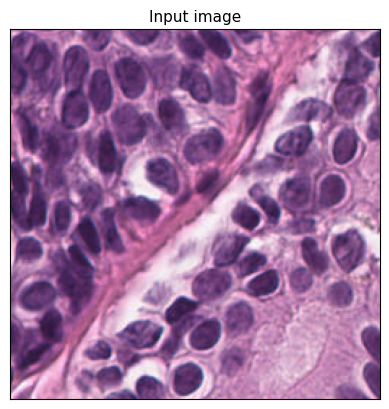

In [7]:
region = wsi.slide.extract_region(location=(0, 0), size=(256, 256))
plt.imshow(region)
plt.title("Input image", fontsize=11)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

### SlideData and Tile Initialization

With the image loaded, we encapsulate it within a `Tile` object, which will be used to apply inference with pre-trained model.

In [8]:
img_tile = Tile(region, coords=(0, 0), stain="HE")

### Apply Inference to Tile

We apply the HoVerNet model to the `Tile` object to perform cell type identification.

In [9]:
hvinf.apply(img_tile)

### Plotting the Segmented Cells

Here we visualize the segmentation results by overlaying the detected cell masks on the image.

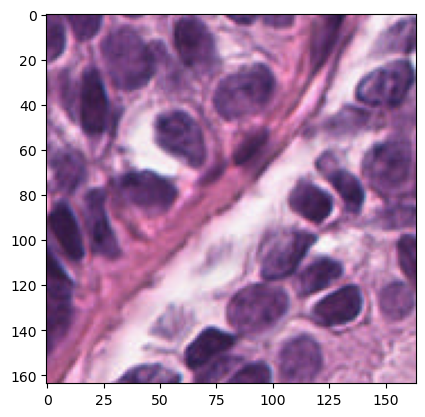

In [10]:
# Plotting image
plt.imshow(img_tile.image)

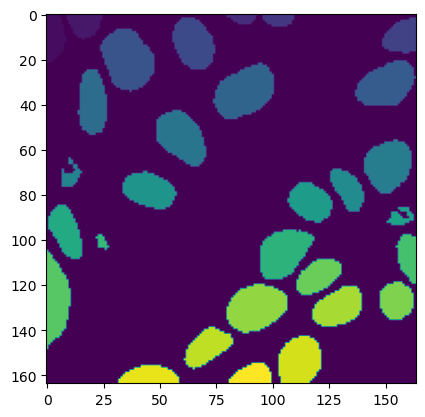

In [11]:
# Below image plots thje cell segmentations
plt.imshow(img_tile.masks["cell"])

3\. Model Inference and Detection of Cell Types
-----------------------------------------------


This section details how we run the inference pipeline over the whole slide image and how to handle the outputs.

### HoVer-Net Inference

The inference pipeline is executed using a pre-trained HoVer-Net model, which predicts the presence and type of cells on a given tile from the WSI. 
Below you can the see code that plots the actual tile image and the overlaid centroid locations. 

Each cell is represented by a specific color code for easy identification:

-   0: Background - Black
-   1: Epithelial - Red
-   2: Lymphocyte - Green
-   3: Macrophage - Blue
-   4: Neutrophil - Yellow

### Run Inference Pipeline on Whole Slide Images

Using a pipeline, we can systematically process the tiles of the WSI and perform inference on each.

In [12]:
wsi = SlideData(
    "../../data/data/example_0_N_0.png", name="example", backend="openslide", stain="HE"
)

In [13]:
# cloud compute or a cluster using dask.distributed.
cluster = LocalCluster(n_workers=10, threads_per_worker=1, processes=True)
client = Client(cluster)

In [14]:
# Execute pipeline by tiling and applying the inference on tiles.

pipeline = Pipeline([HoVerNetInference(model_path="../hovernet_monusac.onnx")])

# Run the Inference Pipeline
wsi.run(
    pipeline,
    tile_size=256,
    tile_stride=164,
    tile_pad=True,
    distributed=True,
    client=client,
)

### Saving the Results

The results of the inference can be saved for further analysis.

In [15]:
# Save it to a file.
# wsi.write('./example_pred_out_padded.h5')

4\. Graph Construction and Feature Extraction
---------------------------------------------

Graph-based analysis is a powerful approach to study the spatial patterns of cells. Here, we construct two types of graphs: K-Nearest Neighbors (KNN) and KNN combined with Minimum Spanning Tree (KNN+MST).

### Group and Rescale Centroids

Centroids are grouped by cell type and rescaled according to the original image dimensions.


In [16]:
def rescale_centroids(centroids, original_size, cropped_size, patch_position=(0, 0)):
    """
    Rescale centroids from a cropped patch to their original position in the larger image.

    Args:
        centroids (list of tuples): List of centroids in the cropped image (x, y format).
        original_size (tuple): The size of the original image (width, height).
        cropped_size (tuple): The size of the cropped image (width, height).
        patch_position (tuple): The top-left position of the patch in the original image (x, y format).

    Returns:
        List of tuples: Rescaled centroids in the original image.
    """
    offset_x = (original_size[0] - cropped_size[0]) // 2
    offset_y = (original_size[1] - cropped_size[1]) // 2

    rescaled_centroids = []
    for centroid in centroids:
        # Adjust for the cropping and then for the position in the original image
        rescaled_x = centroid[0] + offset_x + patch_position[0]
        rescaled_y = centroid[1] + offset_y + patch_position[1]
        rescaled_centroids.append((rescaled_x, rescaled_y))

    return rescaled_centroids

In [17]:
def plot_centroids_on_region(
    extracted_region, rescaled_dict, extraction_location, dot_size=5, color_map=None
):
    """
    Plot colored dots on the extracted region of an image at specified centroid locations.

    Args:
        extracted_region (numpy.ndarray): The extracted region of the image.
        grouped_centroids (dict): Dictionary of centroids grouped by cell type.
        extraction_location (tuple): The top-left (x, y) coordinates where the region was extracted from the full image.
        dot_size (int): Size of the dot for each centroid. Default is 5.
        color_map (dict): Mapping of cell types to colors.
    """
    if not isinstance(extracted_region, np.ndarray):
        raise ValueError("extracted_region must be a numpy array.")
    if not isinstance(rescaled_dict, dict):
        raise ValueError("rescaled_dict must be a dictionary.")

    if color_map is None:
        # Default color map
        color_map = {0: "black", 1: "red", 2: "green", 3: "blue", 4: "yellow"}

    # Convert numpy array to PIL Image for drawing
    region_image = Image.fromarray(np.uint8(extracted_region))
    draw = ImageDraw.Draw(region_image)

    # Draw a colored dot for each centroid based on its cell type
    for cell_type, centroids in rescaled_dict.items():
        for centroid in centroids:
            adjusted_x, adjusted_y = (
                centroid[0] - extraction_location[0],
                centroid[1] - extraction_location[1],
            )
            # Include centroid only if it falls within the extracted region
            if (
                0 <= adjusted_x < extracted_region.shape[1]
                and 0 <= adjusted_y < extracted_region.shape[0]
            ):
                draw.ellipse(
                    [
                        (adjusted_x - dot_size, adjusted_y - dot_size),
                        (adjusted_x + dot_size, adjusted_y + dot_size),
                    ],
                    fill=color_map[cell_type],
                )

    # Convert back to numpy array for plotting
    region_with_centroids = np.array(region_image)
    plt.imshow(region_with_centroids)
    plt.title("Region with Centroids", fontsize=11)
    plt.axis("off")
    plt.show()

To ensure the reliability of our data, we only consider cells with a detection probability above a certain threshold. This minimizes false positives and refines our dataset for the construction of spatial graphs. Here, the probability_threshold is set to 0.5

Tile ID: (0, 0)


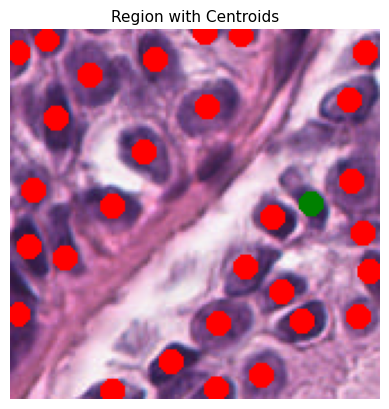

[0. 1. 2.]
Tile ID: (0, 1148)


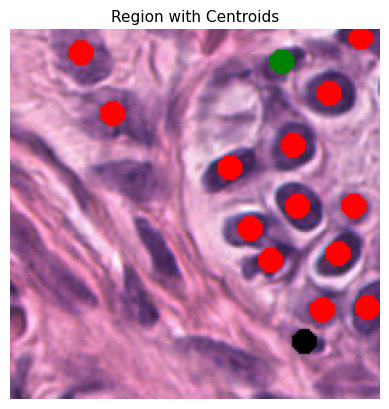

[0. 1. 2.]
Tile ID: (0, 1312)


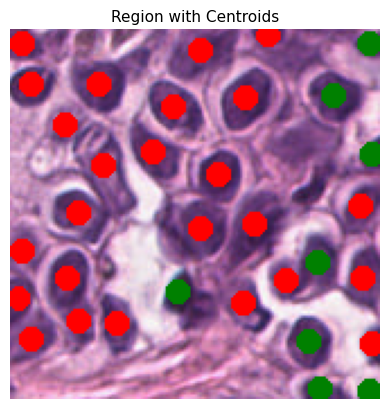

[0. 1. 2.]
Tile ID: (0, 1476)


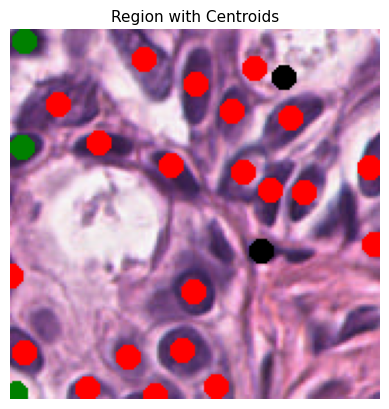

[0. 1. 2.]
Tile ID: (0, 164)


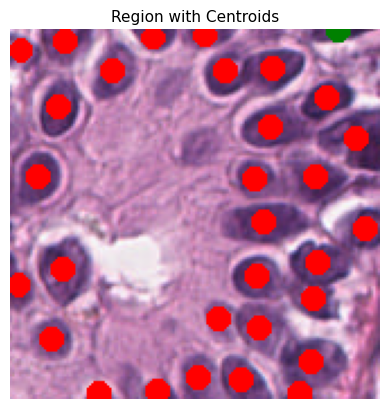

[0. 1. 2.]
Tile ID: (0, 1640)


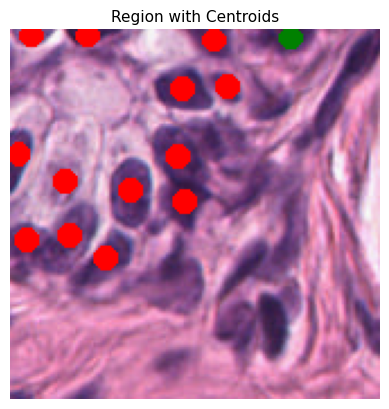

[0. 1. 2.]


In [18]:
# Initialize the dictionary to accumulate all rescaled centroids
all_rescaled_centroids = {0: [], 1: [], 2: [], 3: [], 4: []}  # Assuming 5 cell types

for idx, tile_key in enumerate(wsi.tiles.keys):
    try:
        curr_tile = wsi.tiles[tile_key]
        extraction_location = curr_tile.coords

        # Get cell information and group centroids
        centers = extract_nuclei_info(
            curr_tile.masks["cell"], curr_tile.masks["nc_out"]
        )

        # Different probability thresholds for different purposes
        prob_threshold_plot = 0.1
        prob_threshold_accumulate = 0.5

        # Group centroids for plotting
        grouped_centroids_plot = group_centroids_by_type(centers, prob_threshold_plot)
        # Group centroids for accumulation
        grouped_centroids_accumulate = group_centroids_by_type(
            centers, prob_threshold_accumulate
        )

        # Rescale centroids for each cell type and accumulate
        for cell_type, centroids in grouped_centroids_accumulate.items():
            formatted_centroids = [(c[0], c[1]) for c in centroids]
            rescaled_ctr = rescale_centroids(
                formatted_centroids,
                original_size=(256, 256),
                cropped_size=(164, 164),
                patch_position=extraction_location,
            )
            all_rescaled_centroids[cell_type].extend(rescaled_ctr)

        # Plotting logic
        if idx <= 5:
            rescaled_dct_for_plot = {}
            for cell_type, centroids in grouped_centroids_plot.items():
                formatted_centroids = [(c[0], c[1]) for c in centroids]
                rescaled_ctr = rescale_centroids(
                    formatted_centroids,
                    original_size=(256, 256),
                    cropped_size=(164, 164),
                    patch_position=extraction_location,
                )
                rescaled_dct_for_plot[cell_type] = rescaled_ctr

            new_loc = (extraction_location[0] + 46, extraction_location[1] + 46)
            print(f"Tile ID: {tile_key}")
            plot_centroids_on_region(curr_tile.image, rescaled_dct_for_plot, new_loc)
            print(np.unique(curr_tile.masks["nc_out"]))
    except Exception as e:
        print(f"An error occurred processing tile {tile_key}: {e}")

### Graph Construction

Using the processed centroids, KNN and KNN+MST graphs are generated. The KNN graph links each cell to its nearest neighbors, forming a network that reflects the local cellular architecture. The KNN+MST graph, on the other hand, is a reduced form that retains the most significant connections based on the minimum spanning tree algorithm, emphasizing the most prominent pathways among cells.

To facilitate the construction of these graphs, we utilize the CentroidGraphBuilder from our graph API. This allows us to efficiently generate both KNN and KNN+MST graphs based solely on the centroid locations of the cells.

In [19]:
lymphocyte_centroids = all_rescaled_centroids[2]
len(lymphocyte_centroids)

202

In [20]:
knn_graphbuilder = KNNGraphBuilder(k=5, return_networkx=True)

knnmst_graphbuilder = MSTGraphBuilder(k=5, return_networkx=True)

In [21]:
knn_graph = knn_graphbuilder.process_with_centroids(np.array(lymphocyte_centroids))
knnmst_graph = knnmst_graphbuilder.process_with_centroids(
    np.array(lymphocyte_centroids)
)

### Extracting Graph Features

Once these graphs are constructed, we can extract features from them using the GraphFeatureExtractor. The extracted features provide insights into the structural organization of TILs in the tissue. The features extracted from the graphs include basic graph properties, degree measures, centrality, constraint and coreness measures which are indicative of the immune response's robustness.

In [22]:
graph_feats = GraphFeatureExtractor(use_weight=False)
graph_feats.process(knn_graph.to_undirected())

{'diameter': 31,
 'radius': 16,
 'assortativity_degree': 0.03083720730780316,
 'density': 0.030392591497955767,
 'transitivity_undir': 0.5949060036385688,
 'hubs_mean': 0.0049504950495049506,
 'hubs_median': 7.424885839912645e-06,
 'hubs_max': 0.0935574608219838,
 'hubs_min': 1.576933520935847e-09,
 'hubs_sum': 1.0,
 'hubs_std': 0.01667537846274762,
 'authorities_mean': 0.004950495049504951,
 'authorities_median': 7.424885839911538e-06,
 'authorities_max': 0.09355746082198403,
 'authorities_min': 1.5769335233280537e-09,
 'authorities_sum': 1.0000000000000002,
 'authorities_std': 0.01667537846274765,
 'constraint_mean': 0.3836177452207771,
 'constraint_median': 0.374923128201898,
 'constraint_max': 0.6156081632653062,
 'constraint_min': 0.2155555555555555,
 'constraint_sum': 77.49078453459697,
 'constraint_std': 0.080788168284748,
 'coreness_mean': 5.0,
 'coreness_median': 5.0,
 'coreness_max': 5,
 'coreness_min': 5,
 'coreness_sum': 1010,
 'coreness_std': 0.0,
 'egvec_centr_mean': 0.02

In [23]:
graph_feats.process(knnmst_graph.to_undirected())

{'diameter': 94,
 'radius': 47,
 'assortativity_degree': -0.25600468658465114,
 'density': 0.009900990099009901,
 'transitivity_undir': 0,
 'hubs_mean': 0.0049504950495049506,
 'hubs_median': 3.817769327213428e-08,
 'hubs_max': 0.07087176454856213,
 'hubs_min': 7.579700645811693e-18,
 'hubs_sum': 1.0,
 'hubs_std': 0.01246477276949842,
 'authorities_mean': 0.0049504950495049506,
 'authorities_median': -8.241795079064003e-18,
 'authorities_max': 0.18922809369896415,
 'authorities_min': -0.07627017300061999,
 'authorities_sum': 1.0,
 'authorities_std': 0.03262467684924925,
 'constraint_mean': 0.5697194719471947,
 'constraint_median': 0.5,
 'constraint_max': 1.0,
 'constraint_min': 0.25,
 'constraint_sum': 115.08333333333333,
 'constraint_std': 0.22644907646158377,
 'coreness_mean': 1.0,
 'coreness_median': 1.0,
 'coreness_max': 1,
 'coreness_min': 1,
 'coreness_sum': 202,
 'coreness_std': 0.0,
 'egvec_centr_mean': 0.02691544651177766,
 'egvec_centr_median': 1.1494280502723807e-05,
 'egvec

In [24]:
def plot_graph(graph):

    pos = nx.spring_layout(graph, scale=2)

    nx.draw_networkx_nodes(graph, pos, node_size=10, node_color="blue")

    nx.draw_networkx_edges(graph, pos, width=2, edge_color="grey")

    plt.axis("off")
    plt.show()

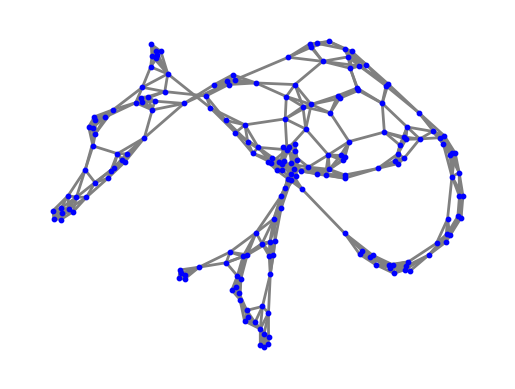

In [25]:
plot_graph(knn_graph.to_undirected())

Conclusion and Further Steps
----------------------------

In summary, this notebook has detailed the application of Inference and Graph techniques to study the spatial distribution of TILs (Tumor Infiltrating Lymphocytes) in NSCLC samples. The approach demonstrated here can be extended to a larger set of WSIs for a comprehensive analysis.

### Modeling and Statistical Testing

Moving beyond the scope of this notebook, the extracted graph features can be used to train predictive models or to perform hypothesis testing. For instance, conducting t-tests or Mann-Whitney U tests on features extracted from pre- and post-ICI treatment samples can highlight significant changes attributed to the treatment, providing valuable insights into the mechanisms of acquired resistance.

### Extending Analysis with Advanced Graph Techniques

In addition to the foundational methods demonstrated, we can significantly enhance our analysis by incorporating advanced methods from the PathML Graph API as described in the "construct_graphs" notebook. These advanced techniques include:

-   Utilizing HoVer-Net for precise cell detection in specific Regions of Interest (ROI).
-   Employing boundary detection for intricate tissue identification.
-   Featurizing detected cells and tissues using ResNet models.
-   Constructing cell and tissue graphs with k-Nearest Neighbor (k-NN) and Region-Adjacency Graph (RAG) methods.

### References

1.  Pocock, J., Graham, S., Vu, Q. D., Jahanifar, M., Deshpande, S., Hadjigeorghiou, G., Shephard, A., Bashir, R. M. S., Bilal, M., Lu, W., Epstein, D., Minhas, F., Rajpoot, N. M., & Raza, S. E. A. (2022). TIAToolbox as an end-to-end library for advanced tissue image analytics. *Communications Medicine*, 2(1), 120. <https://www.nature.com/articles/s43856-022-00186-5>. DOI: 10.1038/s43856-022-00186-5.

2.  Graham, S., Vu, Q. D., Raza, S. E. A., Azam, A., Tsang, Y. W., Kwak, J. T., & Rajpoot, N. (2019). HoVer-Net: Simultaneous segmentation and classification of nuclei in multi-tissue histology images. *Medical Image Analysis*, 58, 101563. <https://www.sciencedirect.com/science/article/abs/pii/S1361841519301045>.
